# Coarse-graining with PCCA+

Robust Perron Cluster Cluster Analysis (PCCA+) <cite data-footcite="roblitz2013fuzzy">(Röblitz, 2013)</cite> is a successor the method PCCA in <cite data-footcite="deuflhard2000identification">(Deuflhard, 2000)</cite>, a spectral clustering algorithm which crisply assigns microstates to clusters. The assignments in PCCA are based on signs of components of eigenvectors, which behaves instably if they are close to zero. That behavior lead to the development of PCCA+, which uses fuzzy assignments rather than crisp ones. Given a [Markov state model](../index_msm.rst) with transition matrix $P\in\mathbb{R}^{n\times n}$, PCCA+ can cluster together (sometimes also referred to as coarse-grain) the $n$ *micro*states into $m<n$ *metastable sets* of states between which also a transition matrix 

$$ P_\mathrm{macro}\in\mathbb{R}^{m\times m} $$

is defined. The method works off of the assumption that the underlying Markov chain is reversible, i.e., given the stationary distribution $\pi$ it obeys the detailed balance condition

$$ \pi_i P_{ij} = \pi_j P_{ji}. $$ 

The result of the clustering is not only the coarse-grained transition matrix
but one also obtains membership probabilities $M\in\mathbb{R}^{n\times m}$ giving a probability distribution of membership for each macrostate to each microstate.

To illustrate the API (API docs [here](../api/generated/deeptime.markov.msm.MarkovStateModel.rst#deeptime.markov.msm.MarkovStateModel.pcca) to cluster an existing MSM and [here](../api/generated/deeptime.markov.pcca.rst) for a direct and functional interface), let us consider a jump process between two ellipsoids in a two-dimensional space:

In [1]:
import numpy as np
from deeptime.data import ellipsoids

data = ellipsoids(laziness=0.97, seed=32).observations(n_steps=5000)

We can visualize the time series as follows. Note that the probability to jump from one ellipsoid to the other  is at $3\%$ for each frame/data point.

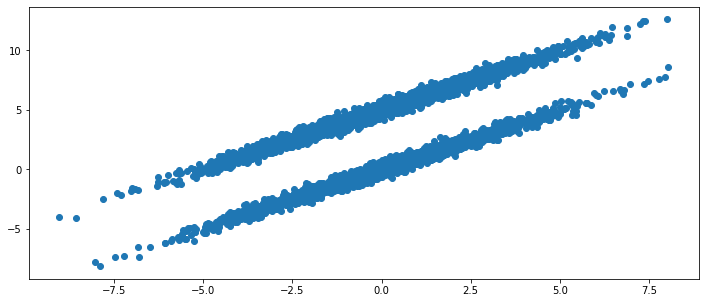

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(*data.T);

To arrive at a [Markov state model](../api/generated/deeptime.markov.msm.MarkovStateModel.rst#deeptime.markov.msm.MarkovStateModel), let us [cluster](../notebooks/clustering.ipynb) the data and assign the frames to the cluster centers.

In [3]:
from deeptime.clustering import KMeans

clustering = KMeans(n_clusters=50, fixed_seed=13) \
    .fit(data).fetch_model()
assignments = clustering.transform(data)

Text(0.5, 1.0, 'cluster center assignments')

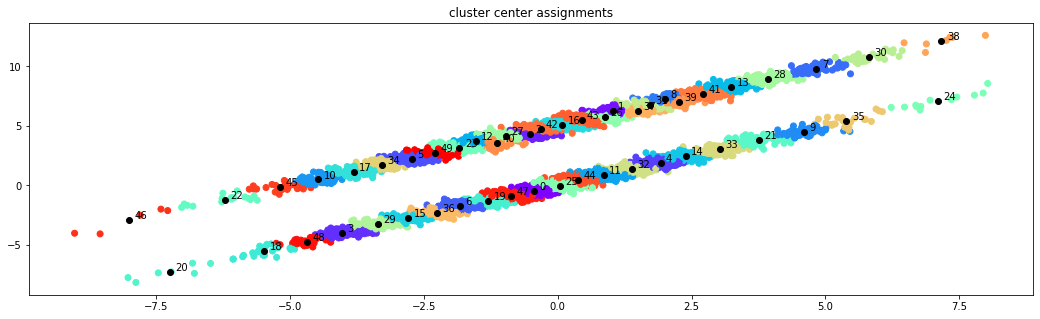

In [4]:
f, ax = plt.subplots(1, 1, figsize=(18, 5))
ax.scatter(*data.T, c=assignments/np.max(assignments), cmap=plt.cm.rainbow)
ax.scatter(*clustering.cluster_centers.T, marker="o", c='black', label='Cluster centers')
for i in range(clustering.n_clusters):
    ax.annotate(f"{i}", clustering.cluster_centers[i], 
                xytext=clustering.cluster_centers[i]+.1)
ax.set_title('cluster center assignments')

A Markov state model can be estimated from the assignments which has as many states as there are cluster centers.

In [5]:
from deeptime.markov.msm import MaximumLikelihoodMSM

msm = MaximumLikelihoodMSM().fit(assignments, lagtime=1).fetch_model()
print(f"Number of states: {msm.n_states}")

Number of states: 50


Plotting the transition matrix with a connectivity threshold discarding weaker connections, one can guess that there are two metastable sets based on the degree of connectedness within one metastable being much higher than in between - but this is not always possible and also not very rigorous.

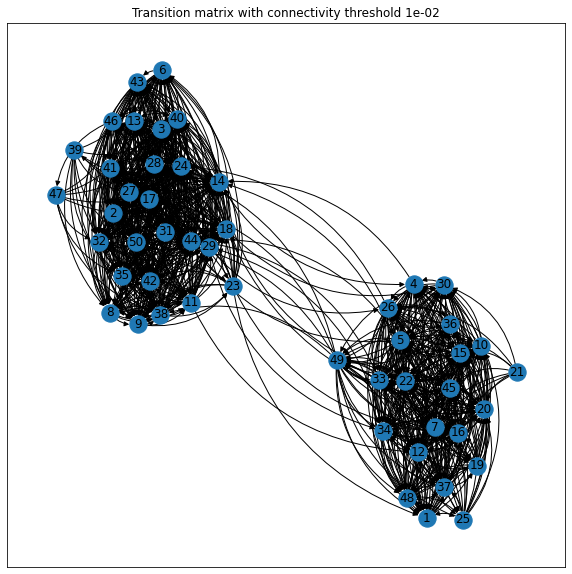

In [6]:
import networkx as nx

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

threshold = 1e-2
title = f"Transition matrix with connectivity threshold {threshold:.0e}"
G = nx.DiGraph()
ax.set_title(title)    
for i in range(msm.n_states):
    G.add_node(i, title=f"{i+1}")
for i in range(msm.n_states):
    for j in range(msm.n_states):
        if msm.transition_matrix[i, j] > threshold:
            G.add_edge(i, j, title=f"{msm.transition_matrix[i, j]:.3e}")

edge_labels = nx.get_edge_attributes(G, 'title')
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, labels=nx.get_node_attributes(G, 'title'));
nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>',
                       connectionstyle='arc3, rad=0.3');

To make it rigorous, let us apply PCCA+ with two metastable sets (in general there might be more, this highly depends on the data):

In [7]:
pcca = msm.pcca(n_metastable_sets=2)

We obtain a coarse transition matrix, where the jump probability between the two sets is roughly $3\%$:

In [8]:
pcca.coarse_grained_transition_matrix

array([[0.96181851, 0.03818149],
       [0.0283872 , 0.9716128 ]])

The membership probabilities can be accessed via `pcca.memberships`, where each column corresponds to a metastable set defining a probability distribution over the microstates:

In [9]:
print(f"Memberships: {pcca.memberships.shape}")

Memberships: (50, 2)


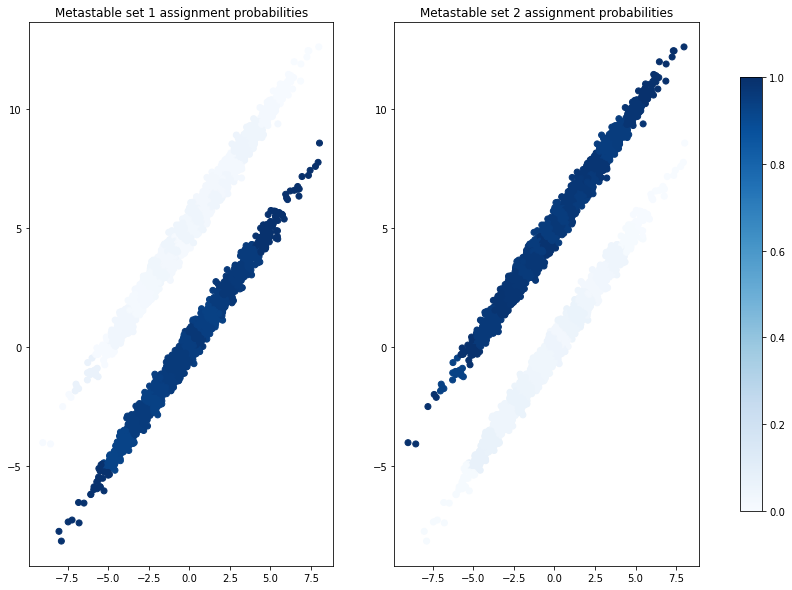

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for i in range(len(axes)):
    ax = axes[i]
    ax.set_title(f"Metastable set {i+1} assignment probabilities")
    
    ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

As expected, the assignments nicely disentangle the two ellipsoids.

One as also access to a coarse-grained stationary probability vector

In [11]:
pcca.coarse_grained_stationary_probability

array([0.42643471, 0.57356529])

Another offered quantity are the metastable distributions, i.e., the probability of metastable states to visit a micro state by PCCA+ $\mathbb{P}(\text{state}_{\text{micro}} | \text{state}_\text{pcca})$:

In [12]:
print("Metastable distributions shape:", pcca.metastable_distributions.shape)

Metastable distributions shape: (2, 50)


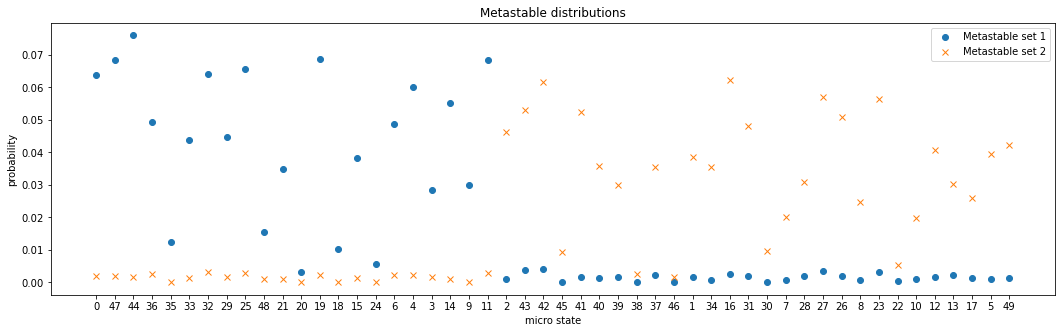

In [13]:
ix = np.argsort(pcca.assignments)
plt.figure(figsize=(18, 5))
plt.plot(np.arange(msm.n_states)+1, pcca.metastable_distributions[0][ix], 'o', label="Metastable set 1")
plt.plot(np.arange(msm.n_states)+1, pcca.metastable_distributions[1][ix], 'x', label="Metastable set 2")
plt.xticks(np.arange(msm.n_states)+1, [f"{i}" for i in ix])
plt.title("Metastable distributions")
plt.legend()
plt.xlabel('micro state')
plt.ylabel('probability');

For all micro states one of the distribution values is approximately zero whereas the other one is greater than zero. This is because micro states were separated well enough in the coarse-graining.

For visualization purposes - as in the plot above - one can obtain the crisp assignments of microstates to macrostates through:

In [14]:
pcca.assignments

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1])

However caution is appropriate, one *cannot* compute any actual quantity of the coarse-grained kinetics without employing the fuzzy memberships.